# **Load and Preprocess the dataset -- Cifar 10**

In [1]:
import tensorflow

# Import CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
import tensorflow.keras.backend as K
from keras.initializers import Initializer, Constant
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,f1_score
from sklearn.model_selection import train_test_split


from scipy.spatial.distance import pdist

import numpy as np
import seaborn as sns
import random
import time

import matplotlib.pyplot as plt
!pip install imbalanced-learn

import imblearn
from imblearn.over_sampling import SMOTE
print(imblearn.__version__)

0.10.1


## **Preprocess Cifar 10**

In [ ]:
#Load data
(XTrain, yTrain), (XTest, yTest) = cifar10.load_data()

unique, counts = np.unique(yTrain, return_counts=True)
print("Training Labels: ", dict(zip(unique, counts)))
unique, counts = np.unique(yTest, return_counts=True)
print("Testing Labels: ", dict(zip(unique, counts)))

# Get the number of features in the test set
numFeatures = XTrain.shape[1]*XTrain.shape[2]*XTrain.shape[3]
print("Number of features in CIFAR-10:", numFeatures)

# Get the number of classes in the test set
numClasses = len(set(yTest.flatten()))
print("Number of classes in CIFAR-10:", numClasses)


print("Train set shape : ", XTrain.shape)
print("Labels for the train set shape :", yTrain.shape)
print("Test set shape :", XTest.shape)
print("Labels for the test set shape :", yTest.shape)

#Convert to float32
XTrain, XTest = np.array(XTrain, dtype=np.float32), np.array(XTest, dtype=np.float32)

# Define the class names
classNames = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Flatten image to 1-D vector
XTrain = XTrain.reshape([-1, numFeatures])
XTest  = XTest.reshape([-1, numFeatures])

# Keep not normalized Train and Test set
XTrainNotScaled = XTrain
XTestNotScaled = XTest

#Normalize to [0,1]
XTrain = XTrain/XTrain.max()
XTest =  XTest/XTest.max()

#Labels without the one-hot encoding (needed in Nearest Centroid)
yTrainLabels = yTrain
yTestLabels = yTest

#One-hot encoding
yTrain, yTest = utils.to_categorical(yTrain, numClasses), utils.to_categorical(yTest, numClasses)

170498071/170498071 [==============================] - 4s 0us/step
Training Labels:  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Testing Labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
Number of features in CIFAR-10: 3072
Number of classes in CIFAR-10: 10
Train set shape :  (50000, 32, 32, 3)
Labels for the train set shape : (50000, 1)
Test set shape : (10000, 32, 32, 3)
Labels for the test set shape : (10000, 1)


## **2-D and 3-D Visualization using PCA**

PCA time elapsed: 10.650320529937744s
Explained variation per principal component: [0.29161653 0.10896879]


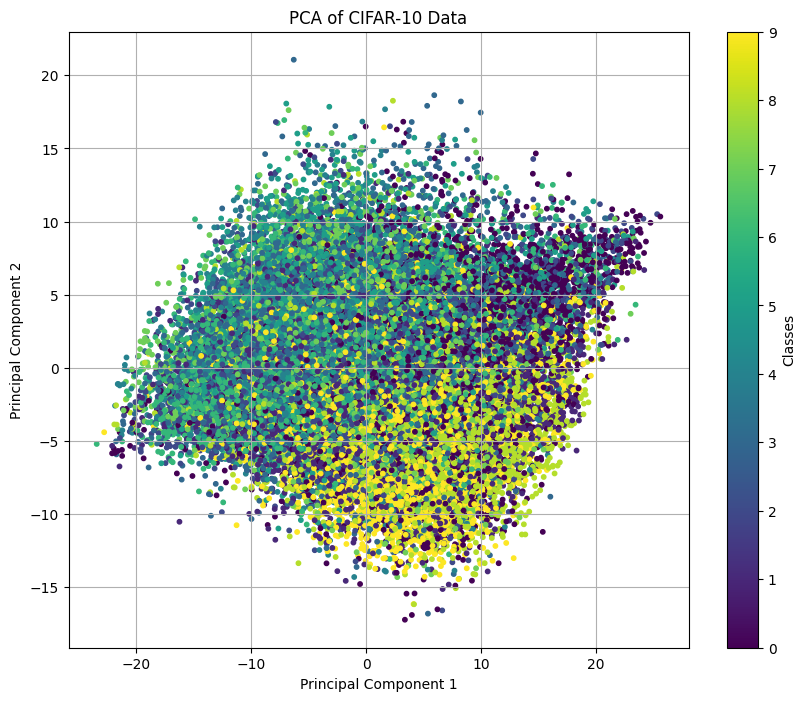

PCA time elapsed: 8.035711765289307s
Explained variation per principal component: [0.29161644 0.10896876 0.06893793]


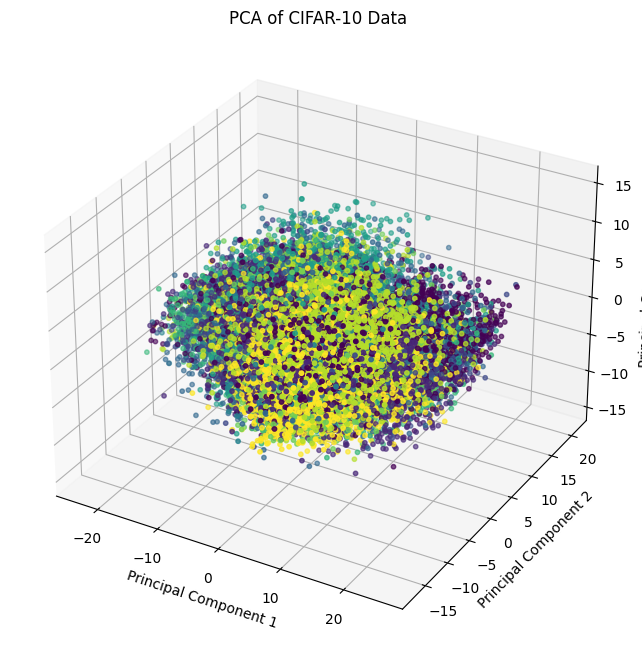

In [ ]:
# Apply PCA Transform with 2 features
start = time.time()
pca = PCA(n_components=2)
XTrainPCA = pca.fit_transform(XTrain)
XTestPCA = pca.fit_transform(XTest)
end = time.time()
print('PCA time elapsed: {}s'.format(end-start))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# Store data
XTrainPCA2 = XTrainPCA
XTestPCA2 = XTestPCA


# 2D Plot after PCA data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(XTrainPCA[:, 0], XTrainPCA[:, 1], c=yTrainLabels, cmap='viridis', s=10)
plt.title('PCA of CIFAR-10 Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Classes')
plt.grid(True)
plt.show()

# Apply PCA Transform with 3 features
start = time.time()
pca = PCA(n_components=3)
XTrainPCA= pca.fit_transform(XTrain)
XTestPCA = pca.fit_transform(XTest)
end = time.time()
print('PCA time elapsed: {}s'.format(end-start))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# Store data
XTrainPCA3 = XTrainPCA
XTestPCA3 = XTestPCA

# 3D Plot after PCA data
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=XTrainPCA[:,0], ys=XTrainPCA[:,1], zs=XTrainPCA[:,2], c=yTrainLabels, cmap='viridis',s=10)
ax.set_title('PCA of CIFAR-10 Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(scatter, label='Classes')
ax.grid(True)
plt.show()

# **ΚNN and Nearest Centroid classification**


##  **KNN Classification**

### **Nearest Neighbor with k=1 neighbor**

In [ ]:
knn1Neighbor = KNeighborsClassifier(n_neighbors=1, p=2)   # use Euclidean distance metric

start = time.time()

knn1Neighbor.fit(XTrainPCA, yTrain)

end = time.time()

print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

score = knn1Neighbor.score(XTestPCA,yTest)
yPred = knn1Neighbor.predict(XTestPCA)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 1-NN classifier accuracy is: {:.4f}".format(score))
print("For the 1-NN classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.181 seconds

Testing time: 17.228 seconds

For the 1-NN classifier accuracy is: 0.1660
For the 1-NN classifier, F1 score is: 0.1661


### **Nearest Neighbor with k=3 neighbors**

In [ ]:
knn3Neighbors = KNeighborsClassifier(n_neighbors=3, p=2)      # use Euclidean distance metric

start = time.time()

knn3Neighbors.fit(XTrainPCA, yTrain)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

score = knn3Neighbors.score(XTestPCA, yTest)
yPred = knn3Neighbors.predict(XTestPCA)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 3-NN classifier accuracy is: {:.4f}".format(score))
print("For the 3-NN classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.081 seconds

Testing time: 18.975 seconds

For the 3-NN classifier accuracy is: 0.0956
For the 3-NN classifier, F1 score is: 0.1332


## **Nearest Centroid Classification**

**Nearest Centroid Classifier with Euclidean Distance metric**

In [ ]:
nearCentroid = NearestCentroid(metric='euclidean')

start = time.time()

nearCentroid.fit(XTrainPCA, yTrainLabels.ravel())

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

scoreNearCentroid = nearCentroid.score(XTestPCA,yTestLabels.ravel())
yPred = nearCentroid.predict(XTestPCA)
f1 = f1_score(yTestLabels, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the Nearest Centroid classifier accuracy is: {:.4f}".format(score))
print("For the Nearest Centroid classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.014 seconds

Testing time: 0.079 seconds

For the Nearest Centroid classifier accuracy is: 0.0956
For the Nearest Centroid classifier, F1 score is: 0.2004


**Nearest Centroid Classifier with Manhattan Distance metric**

In [ ]:
nearCentroid = NearestCentroid(metric='manhattan')  # use manhattan distance metric

start = time.time()

nearCentroid.fit(XTrainPCA, yTrainLabels.ravel())

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

scoreNearCentroid = nearCentroid.score(XTestPCA,yTestLabels.ravel())
yPred = nearCentroid.predict(XTestPCA)
f1 = f1_score(yTestLabels, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the Nearest Centroid classifier accuracy is: {:.4f}".format(score))
print("For the Nearest Centroid classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.019 seconds

Testing time: 0.015 seconds

For the Nearest Centroid classifier accuracy is: 0.0956
For the Nearest Centroid classifier, F1 score is: 0.2054


# **Perform PCA to Train and Test set**

In [8]:
pca = PCA(n_components=0.95).fit(XTrain)
XTrainPCA = pca.transform(XTrain)
XTestPCA  = pca.transform(XTest)

print('Number of features after PCA :',XTrainPCA.shape[1])

Number of features after PCA : 258


# **Functions that may be used**

In [9]:
def rbfKernel(X, Y, gamma=1.0):
    K = np.zeros((X.shape[0], Y.shape[0]))

    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            # Compute squared Euclidean distance
            squaredDistance = np.linalg.norm(x - y) ** 2
            # Compute RBF kernel value
            K[i, j] = np.exp(-gamma * squaredDistance)

    return K

def rbfKernelDerivative(X, Y, gamma=1.0):
    derivatives = np.zeros((X.shape[0], Y.shape[0]))

    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            # Compute squared Euclidean distance
            squaredDistance = np.linalg.norm(x - y) ** 2
            # Compute RBF kernel derivative for this pair of points
            derivative = -2 * gamma * (x - y) * np.exp(-gamma * squaredDistance)
            derivatives[i, j] = np.sum(derivative)  # Sum the derivatives for each dimension

    return derivatives


# loss function and its derivative
def MSE(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2)) ;

def MSEDerivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size ;

def f1Score(yTrue, yPrediction):
    truePositives = K.sum(K.round(K.clip(yTrue * yPrediction, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPrediction, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))

    # Calculate recall
    recall = truePositives / (possiblePositives+K.epsilon())
    # Calculate precision
    precision = truePositives / (predictedPositives+K.epsilon())

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **RBF Neural Network Implementation**

In [ ]:
def RBF(numCenters, x_train, y_train, yTrainLabels, x_test, yTestLabels, lr=0.01,epochs=20,metrics=True,trainEpochs=False):
    print("Number of centers: {}\n".format(numCenters))

    # Apply K-Means to find the centers of the kernels in the hidden layer
    start = time.time()
    kmeans = KMeans(n_clusters=numCenters, init='k-means++', n_init=10, verbose=0).fit(x_train)
    end = time.time()
    print("KMeans elapsed time: {:.3f} seconds".format(end-start))

    # Centers of the kernels
    centers = kmeans.cluster_centers_

    # Variance of each kernel
    distances = pdist(centers, metric='euclidean')
    maxDistance = np.amax(distances)
    var = ((maxDistance / tensorflow.math.sqrt(2*float(centers.shape[0]))))

    # Pass training data through the kernels
    start = time.time()
    kernelXTrain = rbfKernel(x_train, Y=centers, gamma=np.float32(1/(2*var)))
    end = time.time()
    print("Transforming training data: {:.3f} seconds".format(end-start))

    # Calculate weights
    start = time.time()
    w = np.dot(np.linalg.pinv(kernelXTrain), yTrain)
    b = np.zeros((1,numClasses))
    end = time.time()
    print("Calculating weights: {:.3f} seconds".format(end-start))

    #yTrainLabels = yTrainLabels.astype(np.int64)
    kernelDerivativeXTrain = rbfKernelDerivative(x_train, Y=centers, gamma=np.float32(1 / (2 * var)))
    dW = np.zeros((x_train.shape[0],numCenters))
    db = np.zeros((x_train.shape[0],1))

    if trainEpochs is True:
      # split train set in train and validation and pass the new sets through the kernels
      XTrainE, XValidation, yTrainE, yValidation = train_test_split(x_train, yTrainLabels, test_size=0.2, random_state=42)
      kernelXTrainE = rbfKernel(XTrainE, Y=centers, gamma=np.float32(1/(2*var)))
      kernelXValidation = rbfKernel(XValidation, Y=centers, gamma=np.float32(1/(2*var)))
      kernelDerivativeXTrainE = rbfKernelDerivative(XTrainE, Y=centers, gamma=np.float32(1 / (2 * var)))

      trainAccuracy = np.zeros((epochs,1))
      validationAccuracy = np.zeros((epochs,1))

      for epoch in range(epochs):
         # Forward pass
         yTrainPred = np.zeros((XTrainE.shape[0],numClasses))
         for j in range(XTrainE.shape[0]):
             yTrainPred[j,:] = (kernelXTrainE[j,:].dot(w)) + b
         yTrainPred = np.argmax(yTrainPred, 1)

         error = np.zeros((XTrainE.shape[0],1))
         for i in range(XTrainE.shape[0]):
             error[i]=-(yTrainE[i]-yTrainPred[i])
             dW[i] = (error[i])*kernelDerivativeXTrainE[i]
             db[i] = (error[i])
             index = yTrainPred[i]
             w[:,index] = (w[:,index] - lr*dW[i])
             #b[0,index] = (b[0,index] - lr*db[i])

         print(f"Epoch {epoch + 1}/{epochs}")
         print('Training set accuracy: ', accuracy_score(yTrainE,yTrainPred))
         trainAccuracy[epoch] = accuracy_score(yTrainE,yTrainPred)

         yValidationPred = np.zeros((XValidation.shape[0],numClasses))
         for j in range(XValidation.shape[0]):
              yValidationPred[j,:] = (kernelXValidation[j,:].dot(w)) + b
         yValidationPred = np.argmax(yValidationPred, 1)

         print('Validation set accuracy: ', accuracy_score(yValidation,yValidationPred))
         validationAccuracy[epoch] = accuracy_score(yValidation,yValidationPred)

    # Evaluate test set
    start = time.time()
    kernelXTest = rbfKernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))
    yTestPred = np.dot(kernelXTest,w)
    yTestPred = np.argmax(yTestPred, 1)
    end = time.time()
    print("Testing elapsed time: {:.3f} seconds\n".format(end-start))

    # Evaluate training set
    yTrainPred = np.dot(kernelXTrain,w)
    yTrainPred = np.argmax(yTrainPred, 1)

    print('Training set accuracy: ', accuracy_score(yTrainLabels,yTrainPred))
    print('Test set accuracy: ', accuracy_score(yTestLabels,yTestPred))
    print('\n')

    if metrics is True:
        labels = [0,1,2,3,4,5,6,7,8,9]
        labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

        #Create and display confusion matrix
        M = confusion_matrix(yTestLabels, yTestPred)
        disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues)
        plt.show

        #Accuracy, precision, recall and f1-score
        print(classification_report(yTestLabels, yTestPred))
        if trainEpochs is True :
           plt.figure()
           plt.plot(trainAccuracy, label='Train Accuracy')
           plt.plot(validationAccuracy, label='Test Accuracy')
           plt.title('Acurracy on training and validation sets')
           plt.ylabel('Accuracy')
           plt.xlabel('Epochs')
           plt.legend()
           plt.show()



Number of centers: 100

KMeans elapsed time: 163.853 seconds
Transforming training data: 53.104 seconds
Calculating weights: 0.874 seconds
Testing elapsed time: 11.146 seconds

Training set accuracy:  0.24816
Test set accuracy:  0.2505


              precision    recall  f1-score   support

           0       0.33      0.34      0.33      1000
           1       0.00      0.00      0.00      1000
           2       0.21      0.27      0.24      1000
           3       0.21      0.07      0.11      1000
           4       0.20      0.46      0.28      1000
           5       0.31      0.26      0.28      1000
           6       0.18      0.30      0.23      1000
           7       0.65      0.05      0.09      1000
           8       0.31      0.61      0.41      1000
           9       0.36      0.14      0.20      1000

    accuracy                           0.25     10000
   macro avg       0.28      0.25      0.22     10000
weighted avg       0.28      0.25      0.22     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


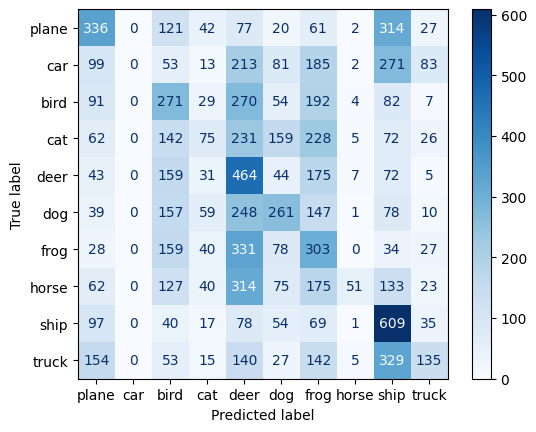

In [ ]:
# Number of features = centers
RBF(100,XTrainPCA,yTrain,yTrainLabels,XTestPCA,yTestLabels)

In [ ]:
# 10 centers
RBF(10,XTrainPCA,yTrain,yTrainLabels,XTestPCA,yTestLabels)

# 20 centers
RBF(20,XTrainPCA,yTrain,yTrainLabels,XTestPCA,yTestLabels)

# 100 centers
RBF(100,XTrainPCA,yTrain,yTrainLabels,XTestPCA,yTestLabels)

# 1000 centers
RBF(1000,XTrainPCA,yTrain,yTrainLabels,XTestPCA,yTestLabels)